In [1]:
# This notebook contains preparation for Horizon tests
# It creates and saves a fake cube with a horizon
import os
import sys
import shutil
import warnings
import numpy as np

warnings.filterwarnings('ignore')

sys.path.insert(0, '../../../seismiqb')
sys.path.insert(0, '..')

from seismiqb import Horizon, Field
from seismiqb.geometry.export import make_segy_from_array
from utils import generate_synthetic

In [2]:
""" You can manage notebook execution kwargs which relates to cube and horizon for the test:

SYNTHETIC_MODE : bool
    Whether to create a synthetic data (cube and horizon) or use existed, provided by paths.
CUBE_PATH : str or None
    Path to an existed seismic cube.
    Notice that it is only used with SYNTHETIC_MODE = False.
HORIZON_PATH : str or None
    Path to an existed seismic horizon.
    Notice that it is only used with SYNTHETIC_MODE = False.
CUBE_SHAPE : sequence of three integers
    Shape of a synthetic cube.
"""
# Synthetic creation parameters
SYNTHETIC_MODE = True
CUBE_PATH = None
HORIZON_PATH = None
CUBE_SHAPE = (500, 500, 200)

# Visualization parameters
SCALE = 1
SHOW_FIGURES = True

# Prepare a workspace

Create directories for files and create a fake cube with horizons and save cube and one horizon.

**Storage structure:**
___



**horizon_test_files** (horizon tests directory with temporary files)

&emsp;├── **test_cube.sgy**

&emsp;├── **test_cube.meta**
    
&emsp;└── **test_horizon**


In [3]:
OUTPUT_DIR = './horizon_test_files'

# (Re)create the test directory
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

os.makedirs(OUTPUT_DIR)

# Create a fake cube and a fake horizon

Finding min/max: 0it [00:00, ?it/s]

Finding min/max:   0%|                                                                                        …

CPU times: user 29.4 s, sys: 6.35 s, total: 35.7 s
Wall time: 35.5 s


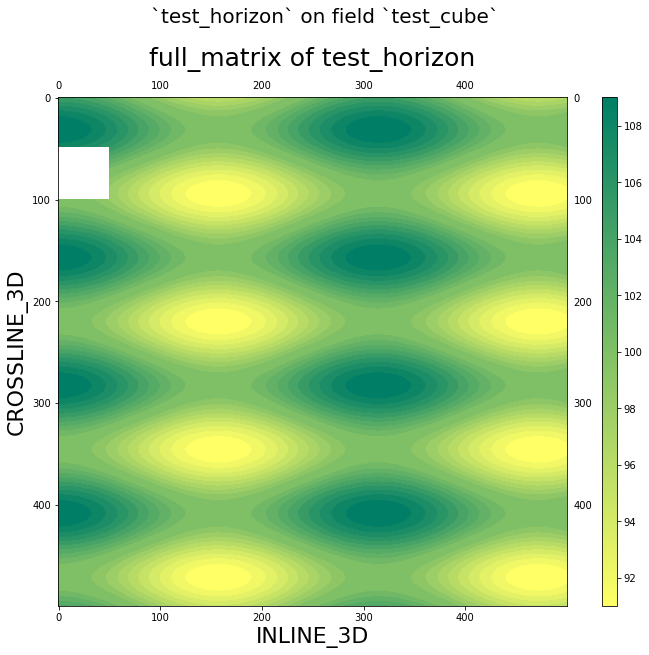

In [5]:
%%time
if SYNTHETIC_MODE:
    CUBE_PATH = os.path.join(OUTPUT_DIR, 'test_cube.sgy')
    HORIZON_PATH = os.path.join(OUTPUT_DIR, 'test_horizon')

    # Create a cube and a horizon
    synt3d, horizon_matrix, _ = generate_synthetic(shape=CUBE_SHAPE)

    # Create zero traces in the cube
    FILL_VALUE = -999999
    points = (slice(0, CUBE_SHAPE[0]//10, None),
              slice(CUBE_SHAPE[0]//10, CUBE_SHAPE[0]//5, None))

    synt3d[points] = FILL_VALUE
    horizon_matrix[points[:2]] = FILL_VALUE

    # Dump data
    make_segy_from_array(synt3d, CUBE_PATH, zip_segy=False)

    # Check cube
    field = Field(CUBE_PATH)

    geometry_loading_error = "Synthetic geometry creation error: saved and loaded data are different"
    assert np.allclose(field.geometry[:, :, :], synt3d), geometry_loading_error

    # Choose one horizon and save it
    horizon = Horizon(horizon_matrix, field=field, name='test')
    horizon.dump(HORIZON_PATH)

    # Check horizon
    opened_horizon = Horizon(HORIZON_PATH, field=field)

    horizon_loading_error = "Synthetic horizon creation error: saved and loaded data are different"
    assert np.array_equal(horizon.full_matrix, opened_horizon.full_matrix), horizon_loading_error
    assert np.array_equal(horizon.points, opened_horizon.points), horizon_loading_error

    opened_horizon.filter()
    opened_horizon.show(show=SHOW_FIGURES, scale=SCALE)